# Cellulus Tutorial: Segmenting 2D Data
In this tutorial we're going to walk through segmenting a 2D cell dataset, assuming very little experience with python. Example code and data will be provided. Feel free to skip any steps that do not apply to your own set-up.

This tutorial will assume that you have python and conda installed. If this is not the case, visit https://www.anaconda.com/ to get set up, then return to this tutorial.

### Creating a virtual environment to work in
We're going to create a conda environment to run cellulus in. The following line scan be executed in ananconda prompt to create and activate a cellulus environment

For this tutorial, you'll also benefit from having numpy and matplotlib installed. They are not essential for Cellulus to run, but help us to view the outputs. Since this is a new environment we're working with, we can isntall them by running the following:

Now that we have all the pre-requisites installed, we can start using Cellulus. Cellulus expects your data to be stored in Zarr container (more on that here https://zarr.readthedocs.io/en/stable/). If your data is not in a zarr format, it needs to be converted. Experienced users could create a dataloader for your own format if preferred.

In this tutorial, w're going to create the configuration files that tell Cellulus hwo to run right here, in the code. Alternatively, this can be done by creating/editing a train.toml file. These are two methods for sharing the same information with Cellulus. 

First, we have to import the configuration classes from the Cellulus library:

In [1]:
from cellulus.configs.experiment_config import ExperimentConfig
from cellulus.configs.model_config import ModelConfig
from cellulus.configs.train_config import TrainConfig
from cellulus.configs.inference_config import InferenceConfig
from cellulus.configs.dataset_config import DatasetConfig

Each of these config classes stores information relevant to a different step in the segmentation process, to give users more control over the end result. Let's create some DatasetConfigs to tell cellulus where to find the zarr files contining the images we want to segement. The dataset we're going to use for demonstration here is a set of lung cell images, taken from the DeepCell TissueNet 1.0 dataset (https://datasets.deepcell.org/data).

We're going to divide our data into a training and validation set. This is commonly done in machine elarning, to ensure that the models we train are applicable to data that isn't in our training dataset, such as data we acquire in the future. If this isn't applicable to you, e.g. you already have all of the data you want to segment, then your train, validation and test configs can all point to the same dataset. 

In [ ]:
train_dataset_config = {'container_path':'[PATH TO YOUR ZARR]',
                                     'dataset_name':'[raw image]'}

validate_dataset_config = {'container_path':'[PATH TO YOUR ZARR]',
                                     'dataset_name':'raw'}

inference_dataset_config = {'container_path':'[PATH TO YOUR ZARR]',
                                     'dataset_name':'raw'}

Let's now define our ModelConfig and TrainConfig. These objects define the structure of the UNet we'll be training, and how we'd like to train it, respectively. The TrainConfig requires the dataset configs we defined earlier. 
The UNet we'll be defining is based on the funlib_torch library. If we already had a pre-trained model, we could supply a checkpoint to taht model, but for now we'll just provide the number of featuremaps and the factor by which to increase the number of feature maps between levels of the U-Net. 

We'll provide some values to define number of iterations we want to train for, and how often the model and snapshots should be saved.

In [ ]:
model_config =  {'num_fmaps':256,
                     'fmap_inc_factor':3,
                     'downsampling_factors':[(3,3)]}

train_config = {'batch_size':8,
                    'save_snapshot_every':200,
                    'save_model_every':200,
                    'train_data_config':train_dataset_config,
                    'validate_data_config':validate_dataset_config,
                    'max_iterations':1000}

Finally, we can define an experiment config. This contains our ModelConfig and TrainConfig, and helps us to ecapsulate all those previouss ettings into a single object, so that the results can be grouped together easily. All we need to do is give the experiment we're running here a name, and an approximate size for the objects we want to segment, given in world units. 

In [4]:
experiment_config = ExperimentConfig(experiment_name="Tutorial Experiment",
                                   object_size=10.0,
                                   model_config=model_config,
                                   train_config=train_config)

We now have all of the information required to run our experiemnt. If you've chosen to define these values in a .toml file instead of in the code, then this next step can be executed from the command line. If you've defined your configs following the steps above, we'll start the training loop from here as well.

In [ ]:
from cellulus.train import train

train(experiment_config)

Once the train function has finished executing, we should have a few new files and folders in our directory. Loss.png gives us a quick glace at the loss curve for our model, approximating how much the model we've trained has improved at creating Object Centric Embeddings. Snapshots.zarr shows us a trained embedding at a few, regular intervals in the training loop. Finally, models stores the trained models, which we can use to segment new images. 

Since we have some data in the lung dataset that the model has never seen (lung.zarr/train), let's see how well our newly trained model performs at segmenting it. 

To do that, we need to define another configuration object, this time an InferenceConfig. The InferenceConfig will contain the paths to the data we want to segment, as well as where we'd like the outputs of each step of the segmentation process saved. 

In [ ]:
pred_output_config = {'container_path':'[PATH TO ZARR OUTPUT]',
                      'dataset_name':'prediction'}

seg_output_config = {'container_path':'[PATH TO ZARR OUTPUT]',
                      'dataset_name':'segmentation'}

postproc_output_config = {'container_path':'[PATH TO ZARR OUTPUT]',
                      'dataset_name':'post_process'}

If you have access to a dataset of ground truth labels for the data you'd like to segment, that can be provided here as well as an evaluation dataset.

In [ ]:
evaluation_dataset_config = {'container_path':'[PATH TO GROUNDTRUTH LABELS]',
                             'dataset_name':'labels'}

In [ ]:
test_inf_config = InferenceConfig(dataset_config=inference_dataset_config,
                                  prediction_dataset_config=pred_output_config,
                                  segmentation_dataset_config=seg_output_config,
                                  post_processed_dataset_config=postproc_output_config,
                                  evaluation_dataset_config=evaluation_dataset_config)

In [ ]:
from cellulus.models import get_model
from cellulus.datasets import get_dataset
import torch

To make predictions and segmentations, we need to load the model that was produced during training. Thankfully, the best performing model (according to the validation dataset) has been saved in the file `best_loss.pth`.

In [ ]:
train_config = experiment_config.train_config
model_config = experiment_config.model_config

train_dataset = get_dataset(
        dataset_config=train_config.train_data_config,
        crop_size=train_config.crop_size,
        control_point_spacing=train_config.control_point_spacing,
        control_point_jitter=train_config.control_point_jitter,
    )

model_example = get_model(
        in_channels=train_dataset.get_num_channels(),
        out_channels=train_dataset.get_num_spatial_dims(),
        num_fmaps=model_config.num_fmaps,
        fmap_inc_factor=model_config.fmap_inc_factor,
        features_in_last_layer=model_config.features_in_last_layer,
        downsampling_factors=model_config.downsampling_factors,
        num_spatial_dims=train_dataset.get_num_spatial_dims(),
    )

model_example = model_example.cuda()

path_to_model = ".models\\best_loss.pth"

model_example.load_state_dict(torch.load(path_to_model)['model_state_dict'])

model_example.eval()

With a good quality model loaded, we can segment our dataset! Producing segmentations is done over three steps, handled by three functions. First we run predict, providing our model and the inference config as arguments. This function will create object-centric embeddings for the dataset that `InferenceConfig.dataset_config` points to. The resulting OCEs will be saved into a zarr container at `InferenceConfig.prediction_dataset_config`.

In [ ]:
from cellulus.predict import predict
predict(model_example,inference_config=test_inf_config)

Once we have our OCEs, we can run `segment()` to cluster those embeddings, to create an instance segmentation

In [ ]:
from cellulus.segment import segment
segment(inference_config=test_inf_config)

Finally, we can post-process the instance segmentation using `post_process()`, to clean up the segmentations we've produced. 

In [ ]:
from cellulus.post_process import post_process
post_process(inference_config=test_inf_config)

Since we're working with 2D data, we can visualise our results easily with matplotlib. We defined the location these post-processed result are stored in earlier, when we created the InferenceConfig.

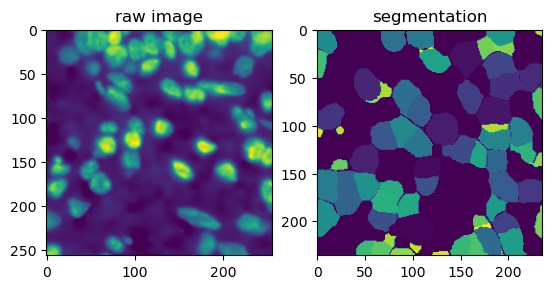

In [10]:
import zarr

test = zarr.open(postproc_output_config['container_path']+'/'+postproc_output_config['dataset_name'],'r')
raw = zarr.open(inference_dataset_config['container_path']+'/'+inference_dataset_config['dataset_name'],'r')
from matplotlib import pyplot as plt

plt.subplot(1,2,1)
plt.title('raw image')
plt.imshow(raw[0,0,:,:])

plt.subplot(1,2,2)
plt.title('segmentation')
plt.imshow(test[0,0,:,:])
plt.show()